# COURSE: A deep understanding of deep learning
## SECTION: Transfer learning
### LECTURE: CodeChallenge: letters to numbers
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401
##### Modified from original code

In [ ]:
# Exercise
# Copy notebook '../19-CNN/11'
# Import both 'letters' and 'digits' from EMNIST dataset
# Train on letters for 5 epochs & Transfer the model to digits
# Fine-tune (1) entire model and (2) only the categorization layers

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import copy
from sklearn.model_selection import train_test_split


# NEW! for importing data
import torchvision

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Import the data

In [4]:
# download the datasets
letterdata = torchvision.datasets.EMNIST(root='../19-CNN/emnist',split='letters')
numberdata = torchvision.datasets.EMNIST(root='../19-CNN/emnist',split='digits')

100%|██████████| 562M/562M [00:03<00:00, 164MB/s]


In [5]:
# transformations on the letter data

# remove N/A class
letterCategories = letterdata.classes[1:]
labels = copy.deepcopy(letterdata.targets)-1

# transform to 4D tensor for conv layers (and transform from int8 to float)
letterImages = letterdata.data.view([letterdata.data.shape[0],1,28,28]).float()
letterImages /= torch.max(letterImages)


# split the images and convert to dataloaders
train_data,test_data, train_labels,test_labels = train_test_split(letterImages, labels, test_size=.1)

# convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# translate into dataloader objects
batchsize = 32
letter_train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
letter_test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [6]:
### transformations on numbers data

# transform to 4D tensor for conv layers (and transform from int8 to float)
numberImages = numberdata.data.view([numberdata.data.shape[0],1,28,28]).float()
numberImages /= torch.max(numberImages)


# split the images and convert to dataloaders
train_data,test_data, train_labels,test_labels = train_test_split(numberImages, numberdata.targets, test_size=.1)

# convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# translate into dataloader objects
batchsize = 32
number_train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
number_test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

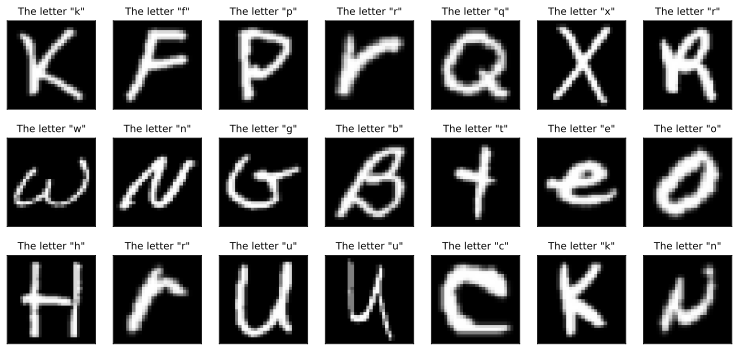

In [7]:
# visualize some letters
fig,axs = plt.subplots(3,7,figsize=(13,6))

# get a batch of letter data
X,y = next(iter(letter_train_loader))

for i,ax in enumerate(axs.flatten()):

  # extract the image and its target letter
  I = np.squeeze( X[i,:,:] )
  letter = letterCategories[y[i]]

  # visualize
  ax.imshow(I.T,cmap='gray',vmin=0,vmax=1)
  ax.set_title('The letter "%s"'%letter,fontsize=10)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

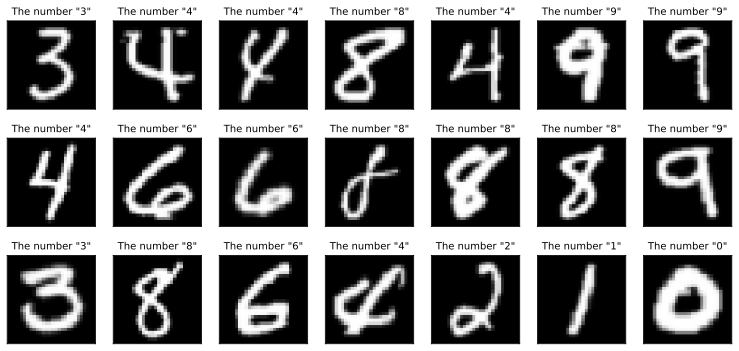

In [8]:
# visualize some numbers
fig,axs = plt.subplots(3,7,figsize=(13,6))

# get a batch of number data
X,y = next(iter(number_train_loader))

for i,ax in enumerate(axs.flatten()):

  # extract the image and its target letter
  I = np.squeeze( X[i,:,:] )
  number = y[i].item()

  # visualize
  ax.imshow(I.T,cmap='gray',vmin=0,vmax=1)
  ax.set_title('The number "%s"'%number,fontsize=10)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Create the DL model

In [9]:
# create a class for the model
def makeTheNet(printtoggle=False):

  class emnistnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(1,6,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(6) # input the number of channels in this layer
      # output size: (28+2*1-3)/1 + 1 = 28/2 = 14 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(6,6,3,padding=1)
      self.bnorm2 = nn.BatchNorm2d(6) # input the number of channels in this layer
      # output size: (14+2*1-3)/1 + 1 = 14/2 = 7 (/2 b/c maxpool)


      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(7*7*6,50)
      self.fc2 = nn.Linear(50,26)

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = self.fc2(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = emnistnet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

# Create a function that trains the model

In [10]:
# a function that trains the model

def function2trainTheModel(net,optimizer,train_loader,test_loader,numepochs=10):

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainErr  = torch.zeros(numepochs)
  testErr   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchErr  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchErr.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainErr[epochi]  = 100*np.mean(batchErr)



    ### test performance
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # get loss and error rate from the test batch
    testLoss[epochi] = loss.item()
    testErr[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainErr,testErr,net

# Train the model on the letters

In [11]:
# create a new model
letterNet,lossfun,optimizer = makeTheNet()

trainLoss,testLoss,trainErr,testErr,letterNet = function2trainTheModel(
                                                letterNet,optimizer,letter_train_loader,letter_test_loader,5)

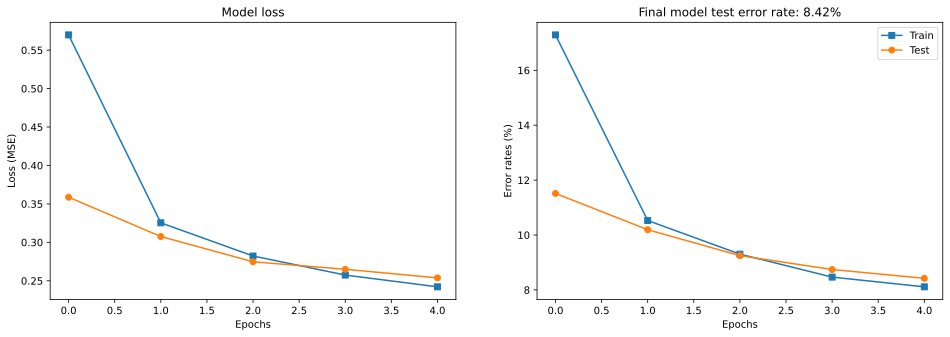

In [12]:
# Examine performance
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(testErr,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show()

# Test the model on the number data

In [13]:
# extract X,y from NUMBER test dataloader
X,y = next(iter(number_test_loader))
X = X.to(device)
y = y.to(device)

letterNet.eval()
yHat = letterNet(X)

# the test (error rate should be TERRIBLY HIGH)
numberAcc = 100*torch.mean((torch.argmax(yHat,axis=1)!=y).float())

print(f'numberNet error rate on NUMBER data: {numberAcc:.2f}%')

numberNet error rate on NUMBER data: 97.77%


# Fine-tune the model with one training batch

In [19]:
# create the target model
numberNet,lossfun,optimizer = makeTheNet()

# then replace all the weights in TARGET model from SOURCE model
for target,source in zip(numberNet.named_parameters(),letterNet.named_parameters()):
  target[1].data = copy.deepcopy( source[1].data )

In [20]:
# check out the network
print(f'----Number Network----\n{numberNet}')
print(' ')

# and the final layer
print(f'----final fc layer----\n{numberNet.fc2}')

# replace the final layer to have 10 outputs instead of 26
numberNet.fc2 = nn.Linear(50,10)

# and check it again
print(' ')
print(f'----Number Network again----\n{numberNet}')

----Number Network----
emnistnet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=294, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=26, bias=True)
)
 
----final fc layer----
Linear(in_features=50, out_features=26, bias=True)
 
----Number Network again----
emnistnet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=294, out_features=50, bias=True)


In [21]:
# now re-train the network on the numbers data

trainLoss,testLoss,trainErr,testErr,numberNet = function2trainTheModel(
                                                   numberNet,optimizer,number_train_loader,number_test_loader,1)

In [22]:
print(f'numberNet TRAIN error rate: {trainErr[-1]:.2f}%')
print(f'numberNet TEST error rate: {testErr[-1]:.2f}%')
# If fine-tune the entire network
# only took 1 epoch to achieve GREAT performance!

numberNet TRAIN error rate: 2.62%
numberNet TEST error rate: 1.16%


# Try again, only train categorization layer

In [24]:
# create the target model
numberNet2,lossfun,optimizer = makeTheNet()

# then replace all the weights in TARGET model from SOURCE model
for target,source in zip(numberNet2.named_parameters(),letterNet.named_parameters()):
  target[1].data = copy.deepcopy( source[1].data )

# adjust number of output units
numberNet2.fc2 = nn.Linear(50,10)

# freeze convolution and batch-norm layers
for p in numberNet2.named_parameters():
  if ('conv' in p[0]) or ('bnorm' in p[0]):
    p[1].requires_grad = False

In [30]:
# Check network
# Note only the FFN part is being trained
print('----Number Network 2----')
for p in numberNet2.named_parameters():
  print(f'LayerName: {p[0]} >> "Freezed?": {p[1].requires_grad}')

----Number Network 2----
LayerName: conv1.weight >> "Freezed?": False
LayerName: conv1.bias >> "Freezed?": False
LayerName: bnorm1.weight >> "Freezed?": False
LayerName: bnorm1.bias >> "Freezed?": False
LayerName: conv2.weight >> "Freezed?": False
LayerName: conv2.bias >> "Freezed?": False
LayerName: bnorm2.weight >> "Freezed?": False
LayerName: bnorm2.bias >> "Freezed?": False
LayerName: fc1.weight >> "Freezed?": True
LayerName: fc1.bias >> "Freezed?": True
LayerName: fc2.weight >> "Freezed?": True
LayerName: fc2.bias >> "Freezed?": True


In [31]:
# now re-train the network on the numbers data
# note we are re-training the numberNet2
trainLoss,testLoss,trainErr,testErr,numberNet2 = function2trainTheModel(
                                                   numberNet2,optimizer,number_train_loader,number_test_loader,1)

In [32]:
print(f'numberNet TRAIN error rate: {trainErr[-1]:.2f}%')
print(f'numberNet TEST error rate: {testErr[-1]:.2f}%')
# the model still does AMAZING with fine-tuning part of the model
# freezing works in this case

numberNet TRAIN error rate: 2.83%
numberNet TEST error rate: 1.25%
